# Image Recognition from Particle Simulator Data

In this Notebook we analyse images taken from a 2D particle simulator used for educational purposes. In this device, small magnetic discs are moving on a flat surface due to air flowing from the sides as well as from underneath to reduce friction (see video below). The particles are confined by repulsive, magnetic bars, located on the four sides of the quadratic surface.

**Flow of program**:
0. split video into individual images (requires `ffmpeg`)
0. find particle positions and save to trajectory file (`.h5` format)
0. calculate distance histogram
0. calculate radial distribution function
0. calculate velocity distribution (todo!)

More here info about the particle tracker
[here](http://soft-matter.github.io/trackpy/dev/index.html)
and examples of how to format Notebooks, see
[here](http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb).

** Important when loading a new video: **
- set `moviefile` below.
- check that the feature extraction is working; if not, tweak arguments for `tp.locate()`. 

In [1]:
# load modules required for the analysis
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
from pandas import DataFrame, Series
import os, pims, scipy, trackpy as tp
from scipy.spatial import distance
from IPython.display import HTML
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})

def video(fname, mimetype):
    video_encoded = open(fname, "rb").read().encode("base64")
    video_tag = '<video controls width="320" alt="test" src="data:video/{0};base64,{1}">'.format(mimetype, video_encoded)
    return HTML(data=video_tag)

### Input Data
The following video of the particle simulation was recorded using a smart phone and this will be the basis of the following analysis.

In [2]:
moviefile   = 'movies/N22-small.mp4' # Input movie
video(moviefile, 'mp4')

### Split movie into individual files

Here we use the command line tool `ffmpeg` to split the movie into individual images as these are easier for the `trackpy` module to handle. This step is done only if the directory `images/` does not exist and if you
load another movie files, do remember to delete `images/` to activate.

In [3]:
imgdir=os.path.splitext(moviefile)[0]
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    !ffmpeg -i $moviefile -f image2 -vcodec mjpeg $imgdir/img-%03d.jpg -v 0

### Locate particles and convert into positions in 2D

Before analysing all the 300 frames found in the 10 sec movie, let's check if the (slow) feature extraction
works for a single frame.

In [4]:
frames = pims.ImageSequence(imgdir+'/img*.jpg', as_grey=True)
print('read',len(frames),'frames.')
f = tp.locate(frames[0], diameter=63, invert=True, percentile=50, noise_size=0)
f.tail()

read 325 frames.


,x,y,mass,size,ecc,signal,raw_mass,ep,frame
17,236.584027,424.748507,175488.611765,15.522059,0.034576,137.545098,339412,0,0
18,336.766145,492.498994,163097.858824,16.193604,0.046697,131.976471,348707,0,0
19,271.066955,505.605841,150170.847059,15.631517,0.016748,117.498039,363858,0,0
20,416.620663,525.949820,161599.341176,16.089615,0.014867,132.533333,372046,0,0
21,208.600356,536.729209,158433.576471,16.173515,0.023592,126.964706,378348,0,0


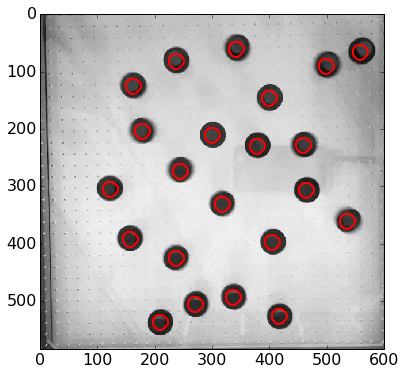

In [5]:
heavy = f[f['mass']>50000] # heavy particles
light = f[f['mass']<50000] # light particles
tp.annotate(f, frames[0])

### Let's analyse it all!

We'll first loop over all frames, extract features and save to trajectory file.
This process is done *only* if the trajectory file, `trjfile`, does not exist,

_Warning: this is a slow process!_

In [6]:
trjfile=os.path.splitext(moviefile)[0]+'.h5'
if not os.path.isfile(trjfile):
    with tp.PandasHDFStore(trjfile) as s:
        for image in frames:
            features = tp.locate(image, diameter=63, invert=True, percentile=50, noise_size=0)
            print('features extracted',len(features))
            s.put(features[['x','y','mass','frame']])

### Read trajectory file and calculate distances between all points

In this section we calculate all distances between all particles for each frame. These are then binned into a histogram to give the probability of observing a particular separation.
At the same time we sample the distribution for _ideal_ particles by simply generating random positions and perform the same analysis as for the "real" particles.

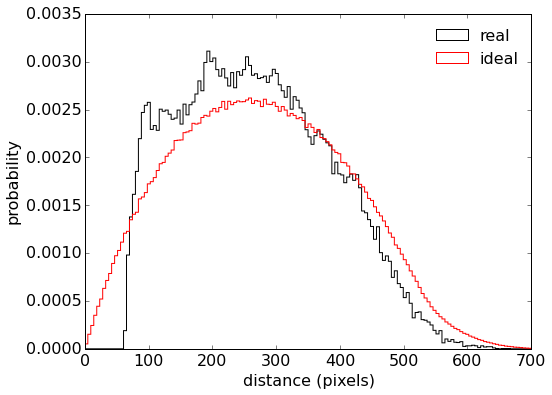

In [7]:
dist  = np.ndarray(shape=(0,0))  # movie distribution
udist = np.ndarray(shape=(0,0))  # uniform distribution

with tp.PandasHDFStore(trjfile) as s:
    # measure all distances between discs
    for frame in s:
        dist = np.append( dist, distance.pdist( frame[['x','y']] ))

    data = s.dump() # save full trajectory to `data`
    
    # find box corners
    xmin,xmax = min(data.x), max(data.x)
    ymin,ymax = min(data.y), max(data.y)
    
    # measure distances for uniform, random distribution (no correlations)
    # (number of points/particles is unimportant.)
    x     = np.random.random_integers(xmin, xmax, 4000)
    y     = np.random.random_integers(ymin, ymax, 4000)
    p     = np.vstack([x, y]).T
    udist = np.append( udist, distance.pdist(p) )
        
    hist  = plt.hist(dist,  bins=150, normed=True, range=[0,700], histtype='step', color='black', label='real')
    uhist = plt.hist(udist, bins=150, normed=True, range=[0,700], histtype='step', color='red', label='ideal')

    plt.legend(loc=0,frameon=False, fontsize=16)
    plt.xlabel('distance (pixels)')
    plt.ylabel('probability')

### Radial Distribution Function, $g(r)$

We have now calculated the distance distribution, `hist`, from the simulated particles from the movie, as well as for a uniform distribution of $N$ particles, `uhist`. The radial distribution function is simply the ratio between the two.
This means that if the particles were behaving ideally (which they don't), `g(r)` would be unity for all separations, $r$.

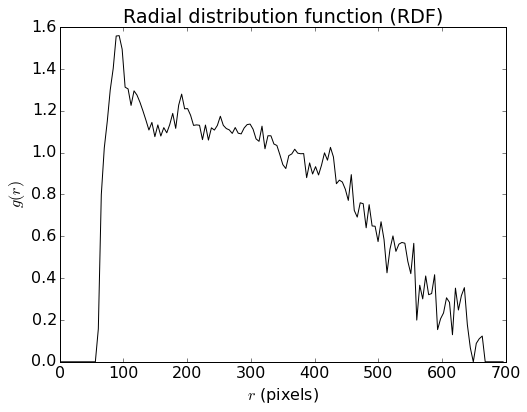

In [8]:
r = hist[1][:len(hist[0])]
g = hist[0] / uhist[0]
plt.plot( r, g, 'k-' )
plt.xlabel('$r$ (pixels)')
plt.ylabel('$g(r)$')
plt.title('Radial distribution function (RDF)')

### Exercises 
0. Why does $g(r)$ not go to unity at large separations?
0. What is the particle size and the system's volume fraction?
0. It seems as if there's a small maximum in $g(r)$ at short separations. Is this real and if so, how is this possible for repulsive particles?
0. Convert $g(r)$ to the potential of mean force and plot this.
0. Repeat the full analysis but for a more concentrated system. Discuss differences.

### Contact
Mikael Lund, 2016 - http://www.teokem.lu.se